In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill, corner, os, pickle
from jax import config, random
config.update('jax_enable_x64', True)
import numpyro, jax
num_chains = 2
numpyro.set_host_device_count(num_chains)

In [2]:
from rochev.hputil import *
from rochev.ldgdutil import lgcoeffs
from rochev import fvmodel_y as fvmodel
from rochev import get_ccfvel_itrnr as get_ccfvel
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer import init_to_value
import celerite2
from celerite2.jax import terms as jax_terms

In [4]:
import seaborn as sns
sns.set(font="times",font_scale=1.4,style="ticks")
sns.set_palette('colorblind')
plt.rcParams["figure.figsize"] = (18,6)
from matplotlib import rc
rc('text', usetex=False)

In [5]:
from astropy.constants import au, R_sun, GM_sun
import astropy.units as u
sma0 = ((GM_sun * (86400 * u.s)**2 / 4 / np.pi**2)**(1./3.)/au).value # a in au for p=1d, mtot=Msun
au_Rsun = (au/R_sun).value
vsini0 = (R_sun*2*np.pi/86400).value*1e-3
print(sma0)
print(f"vsini0 = {vsini0}, [2piR/1year(s)]")

0.019570460672296567
vsini0 = 50.59273169218562, [2piR/1year(s)]


# data

In [8]:
data = pd.read_csv("s12_rv.csv")
dlab = 'S12'
t = jnp.array(data.BJD)
y = jnp.array(data.rv)
yerr = jnp.array(data.rv_err)
t_epoch = t[0]
wavmin, wavmax = 388, 882 # wavelength coverage
idx = t!=2454073.62965 # outlier
print (t_epoch)

2454065.57926


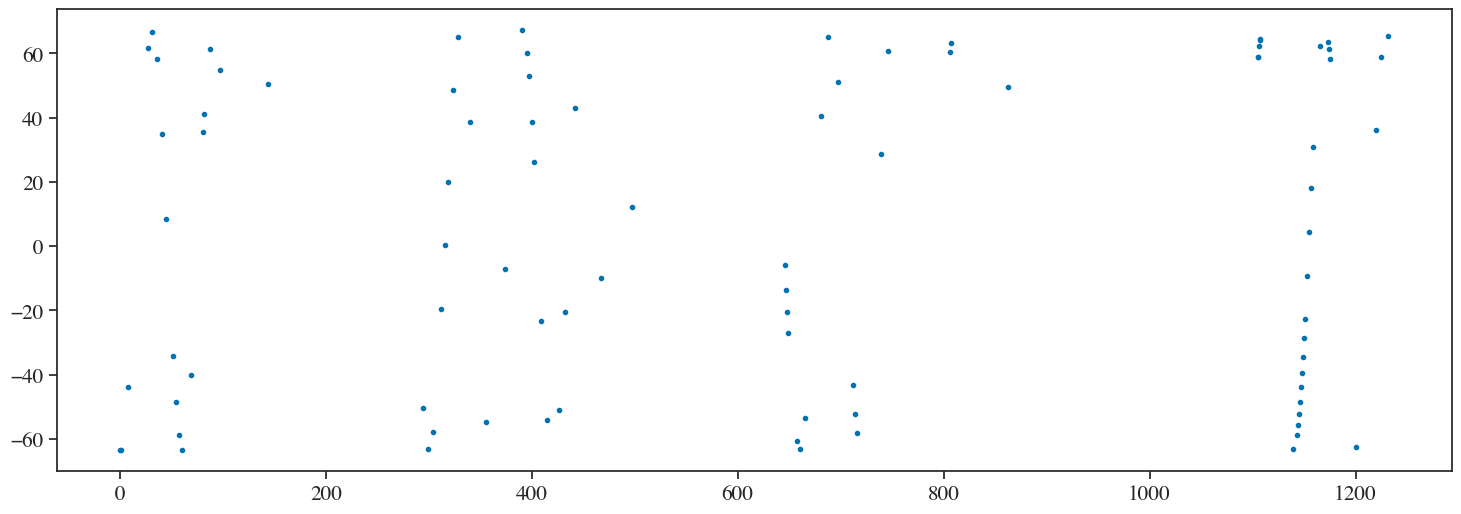

In [9]:
t -= t_epoch
t, y, yerr = t[idx], y[idx], yerr[idx]
plt.plot(t, y, '.')

# model

In [10]:
logm1_min, logm1_max = jnp.log10(0.1), jnp.log10(3.)
logr1_min, logr1_max = jnp.log10(15.), jnp.log10(30.)
logq_min, logq_max = jnp.log10(1.), jnp.log10(10.)
period_min, period_max = 59.9, 60.
t0_min, t0_max = 764.5, 765.5
gamma_min, gamma_max = -10, 10
logalpha_min, logalpha_max = jnp.log10(1.), jnp.log10(5.)

def model(t, y, vsini_loc, vsini_scale, vmac_loc, vmac_scale, minfo, cosi=True):
    
    period_scaled = numpyro.sample("period_scaled", dist.Uniform())
    period = numpyro.deterministic("period", period_scaled * (period_max-period_min) + period_min)

    t0_scaled = numpyro.sample("t0_scaled", dist.Uniform())
    t0 = numpyro.deterministic("t0", t0_scaled * (t0_max-t0_min) + t0_min)

    if cosi:
        cosi = numpyro.sample("cosi", dist.Uniform())
        sini = numpyro.deterministic("sini", jnp.sqrt(1.-cosi*cosi))
        inc = numpyro.deterministic("inc", jnp.arccos(cosi))
        numpyro.deterministic("inc_deg", inc*180/jnp.pi)
    else:
        inc = numpyro.sample("inc", dist.Uniform(low=0., high=jnp.pi/2.))
        sini = numpyro.deterministic("sini", jnp.sin(inc))
        cosi = numpyro.deterministic("cosi", jnp.cos(inc))
        numpyro.deterministic("inc_deg", inc*180/jnp.pi)

    vsini = numpyro.sample("vsini", dist.TruncatedNormal(loc=vsini_loc, scale=vsini_scale, low=0.))
    r1 = numpyro.deterministic("r1", vsini/vsini0/sini*period)
    
    logq_scaled = numpyro.sample("logq_scaled", dist.Uniform())
    logq = numpyro.deterministic("logq", logq_scaled * (logq_max-logq_min) + logq_min)
    q = numpyro.deterministic("q", 10**logq)

    a_crit = numpyro.deterministic("a_crit", (0.6*q**(-2./3.) + jnp.log(1+q**(-1./3.)))/(0.49*q**(-2./3.)))
    logalpha_scaled = numpyro.sample("logalpha_scaled", dist.Uniform())
    logalpha = numpyro.deterministic("logalpha", logalpha_scaled * (logalpha_max-logalpha_min) + logalpha_min)
    alpha = numpyro.deterministic("alpha", 10**logalpha)
    a_r1 = numpyro.deterministic("a_r1", alpha*a_crit)
    a_au = a_r1 * r1 / au_Rsun # a in au
    mtotal = numpyro.deterministic("mtotal", (a_au / sma0)**3 / period**2)

    m1 = numpyro.deterministic("m1", mtotal / (1 + q))
    m2 = numpyro.deterministic("m2", mtotal * q / (1 + q))

    gamma_scaled = numpyro.sample("gamma_scaled", dist.Uniform())
    gamma = numpyro.deterministic("gamma", gamma_scaled * (gamma_max-gamma_min) + gamma_min)

    fm = numpyro.deterministic("fm", (m2*sini)**3 / mtotal**2)
    K = numpyro.deterministic("K", (fm/1.036e-7/period)**(1./3.))
    
    weff = numpyro.sample("weff", dist.TruncatedNormal(loc=(wavmax+wavmin)/2., scale=(wavmax-wavmin)/4., low=wavmin, high=wavmax))
    _ygd, _u1, _u2 = lgcoeffs(weff)
    ygd = numpyro.sample("ygd", dist.Normal(loc=_ygd, scale=0.1))
    u1 = numpyro.sample("u1", dist.Normal(loc=_u1, scale=0.1))
    u2 = numpyro.sample("u2", dist.Normal(loc=_u2, scale=0.1))
    vmac = numpyro.sample("vmac", dist.TruncatedNormal(loc=vmac_loc, scale=vmac_scale, low=0))
    vsigma = numpyro.sample("vsigma", dist.TruncatedNormal(loc=3., scale=0.5, low=2.5))

    x = 2 * jnp.pi * (t - t0) / period
    phases = x + 0.5 * jnp.pi
    rvbase = -K * jnp.sin(x)
    rvbase = rvbase + gamma

    Xf, V, cosg, _ = fvmodel(minfo, phases, inc, u1, u2, q, a_r1, ygd)
    flux = jnp.sum(Xf, axis=1)
    vel_cent = vsini * jnp.sum(V*Xf, axis=1) / flux
    drv = get_ccfvel(vel_cent, Xf, V, cosg, vsini, vmac, vsigma)

    rvs = rvbase + drv
    numpyro.deterministic("rvmodel", rvs)
    numpyro.deterministic("rvmodel_base0", rvbase)
    numpyro.deterministic("rvmodel_base", rvbase)
    numpyro.deterministic("rvmodel_anom", drv)
    numpyro.deterministic("fluxmodel", flux)

    res = y - rvs
    lna = numpyro.sample("lna", dist.Uniform(low=-3, high=1))
    lnc = numpyro.sample("lnc", dist.Uniform(low=-3, high=5))
    lnsigma = numpyro.sample("lnsigma", dist.Uniform(low=-5, high=1))
    
    kernel = jax_terms.Matern32Term(sigma=jnp.exp(lna), rho=jnp.exp(lnc))
    diags = yerr**2 + jnp.exp(2*lnsigma)
    gp = celerite2.jax.GaussianProcess(kernel, mean=0.0)
    gp.compute(t, diag=diags)

    numpyro.sample("obs", gp.numpyro_dist(), obs=res)
    numpyro.deterministic("gppred", gp.predict(res))

# setup and run HMC

In [25]:
vsini_loc, vsini_scale = 15.7, 1.
vmac_loc, vmac_scale = 2.0, 1.1

In [12]:
#%% choose resolution of healpix map
nside = 8 #should be >=8
minfo = hpmap_info(create_hpmap(nside))

approximate resolution: 7.33deg


In [13]:
def normalize(x, xmin, xmax):
    return (x - xmin) / (xmax - xmin)

pdict_init = {#"logm1_scaled": normalize(np.log10(0.5), logm1_min, logm1_max), 
        "logr1_scaled": normalize(np.log10(20.), logr1_min, logr1_max),
        "logq_scaled": normalize(np.log10(5), logq_min, logq_max),
        "period_scaled": normalize(59.937, period_min, period_max),
        "t0_scaled": normalize(764.97, t0_min, t0_max),
        "gamma_scaled": normalize(0, gamma_min, gamma_max)}

In [14]:
init_strategy = init_to_value(values=pdict_init)

In [15]:
kernel = numpyro.infer.NUTS(model, init_strategy=init_strategy, dense_mass=True)

In [16]:
n_warmup, n_sample = 500, 3000

In [17]:
basename = "fiducial_n%d"%nside
if num_chains > 1:
    basename += "_c%d"%num_chains
basename += '_nw%d_ns%d'%(n_warmup, n_sample)
print(basename)

fiducial_n8_c2_nw500_ns3000


In [18]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=n_warmup, num_samples=n_sample, num_chains=num_chains)

In [18]:
num_chains

2

In [19]:
posterior = basename + "_mcmc.pkl"
if os.path.exists(posterior):
    print (posterior + " loaded.")
    mcmc = dill.load(open(posterior, 'rb'))
else:
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, t, y, vsini_loc, vsini_scale, vmac_loc, vmac_scale, minfo, extra_fields=('potential_energy', 'num_steps', 'adapt_state'))
    with open(posterior, "wb") as f:
        dill.dump(mcmc, f)

fiducial_n8_c2_nw500_ns3000_mcmc.pkl loaded.


In [20]:
mcmc.print_summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
             cosi      0.14      0.10      0.13      0.00      0.28   3541.42      1.00
     gamma_scaled      0.59      0.00      0.59      0.59      0.60   5385.72      1.00
              lna     -1.63      0.18     -1.62     -1.89     -1.32   1311.52      1.00
              lnc      0.88      0.48      0.93      0.29      1.53    295.35      1.01
          lnsigma     -3.80      0.77     -3.87     -5.00     -2.71   2099.67      1.00
  logalpha_scaled      0.09      0.02      0.09      0.05      0.12   1997.42      1.00
      logq_scaled      0.74      0.07      0.74      0.62      0.87   1256.47      1.00
    period_scaled      0.37      0.01      0.37      0.35      0.39   5730.10      1.00
        t0_scaled      0.47      0.01      0.47      0.45      0.48   4858.85      1.00
               u1      0.69      0.19      0.68      0.38      1.00   2954.29      1.00
               u2      0.13    

In [21]:
samples = mcmc.get_samples()

## corner plot

In [22]:
samples['alpha_inv'] = 1. / samples['alpha']
keys = ["m1", "m2", "r1", "q", "t0", "period", "cosi", "vsini", "vsigma", "vmac", "gamma", "lna", "lnc", "lnsigma"] + ['alpha_inv', 'K']
labels = keys

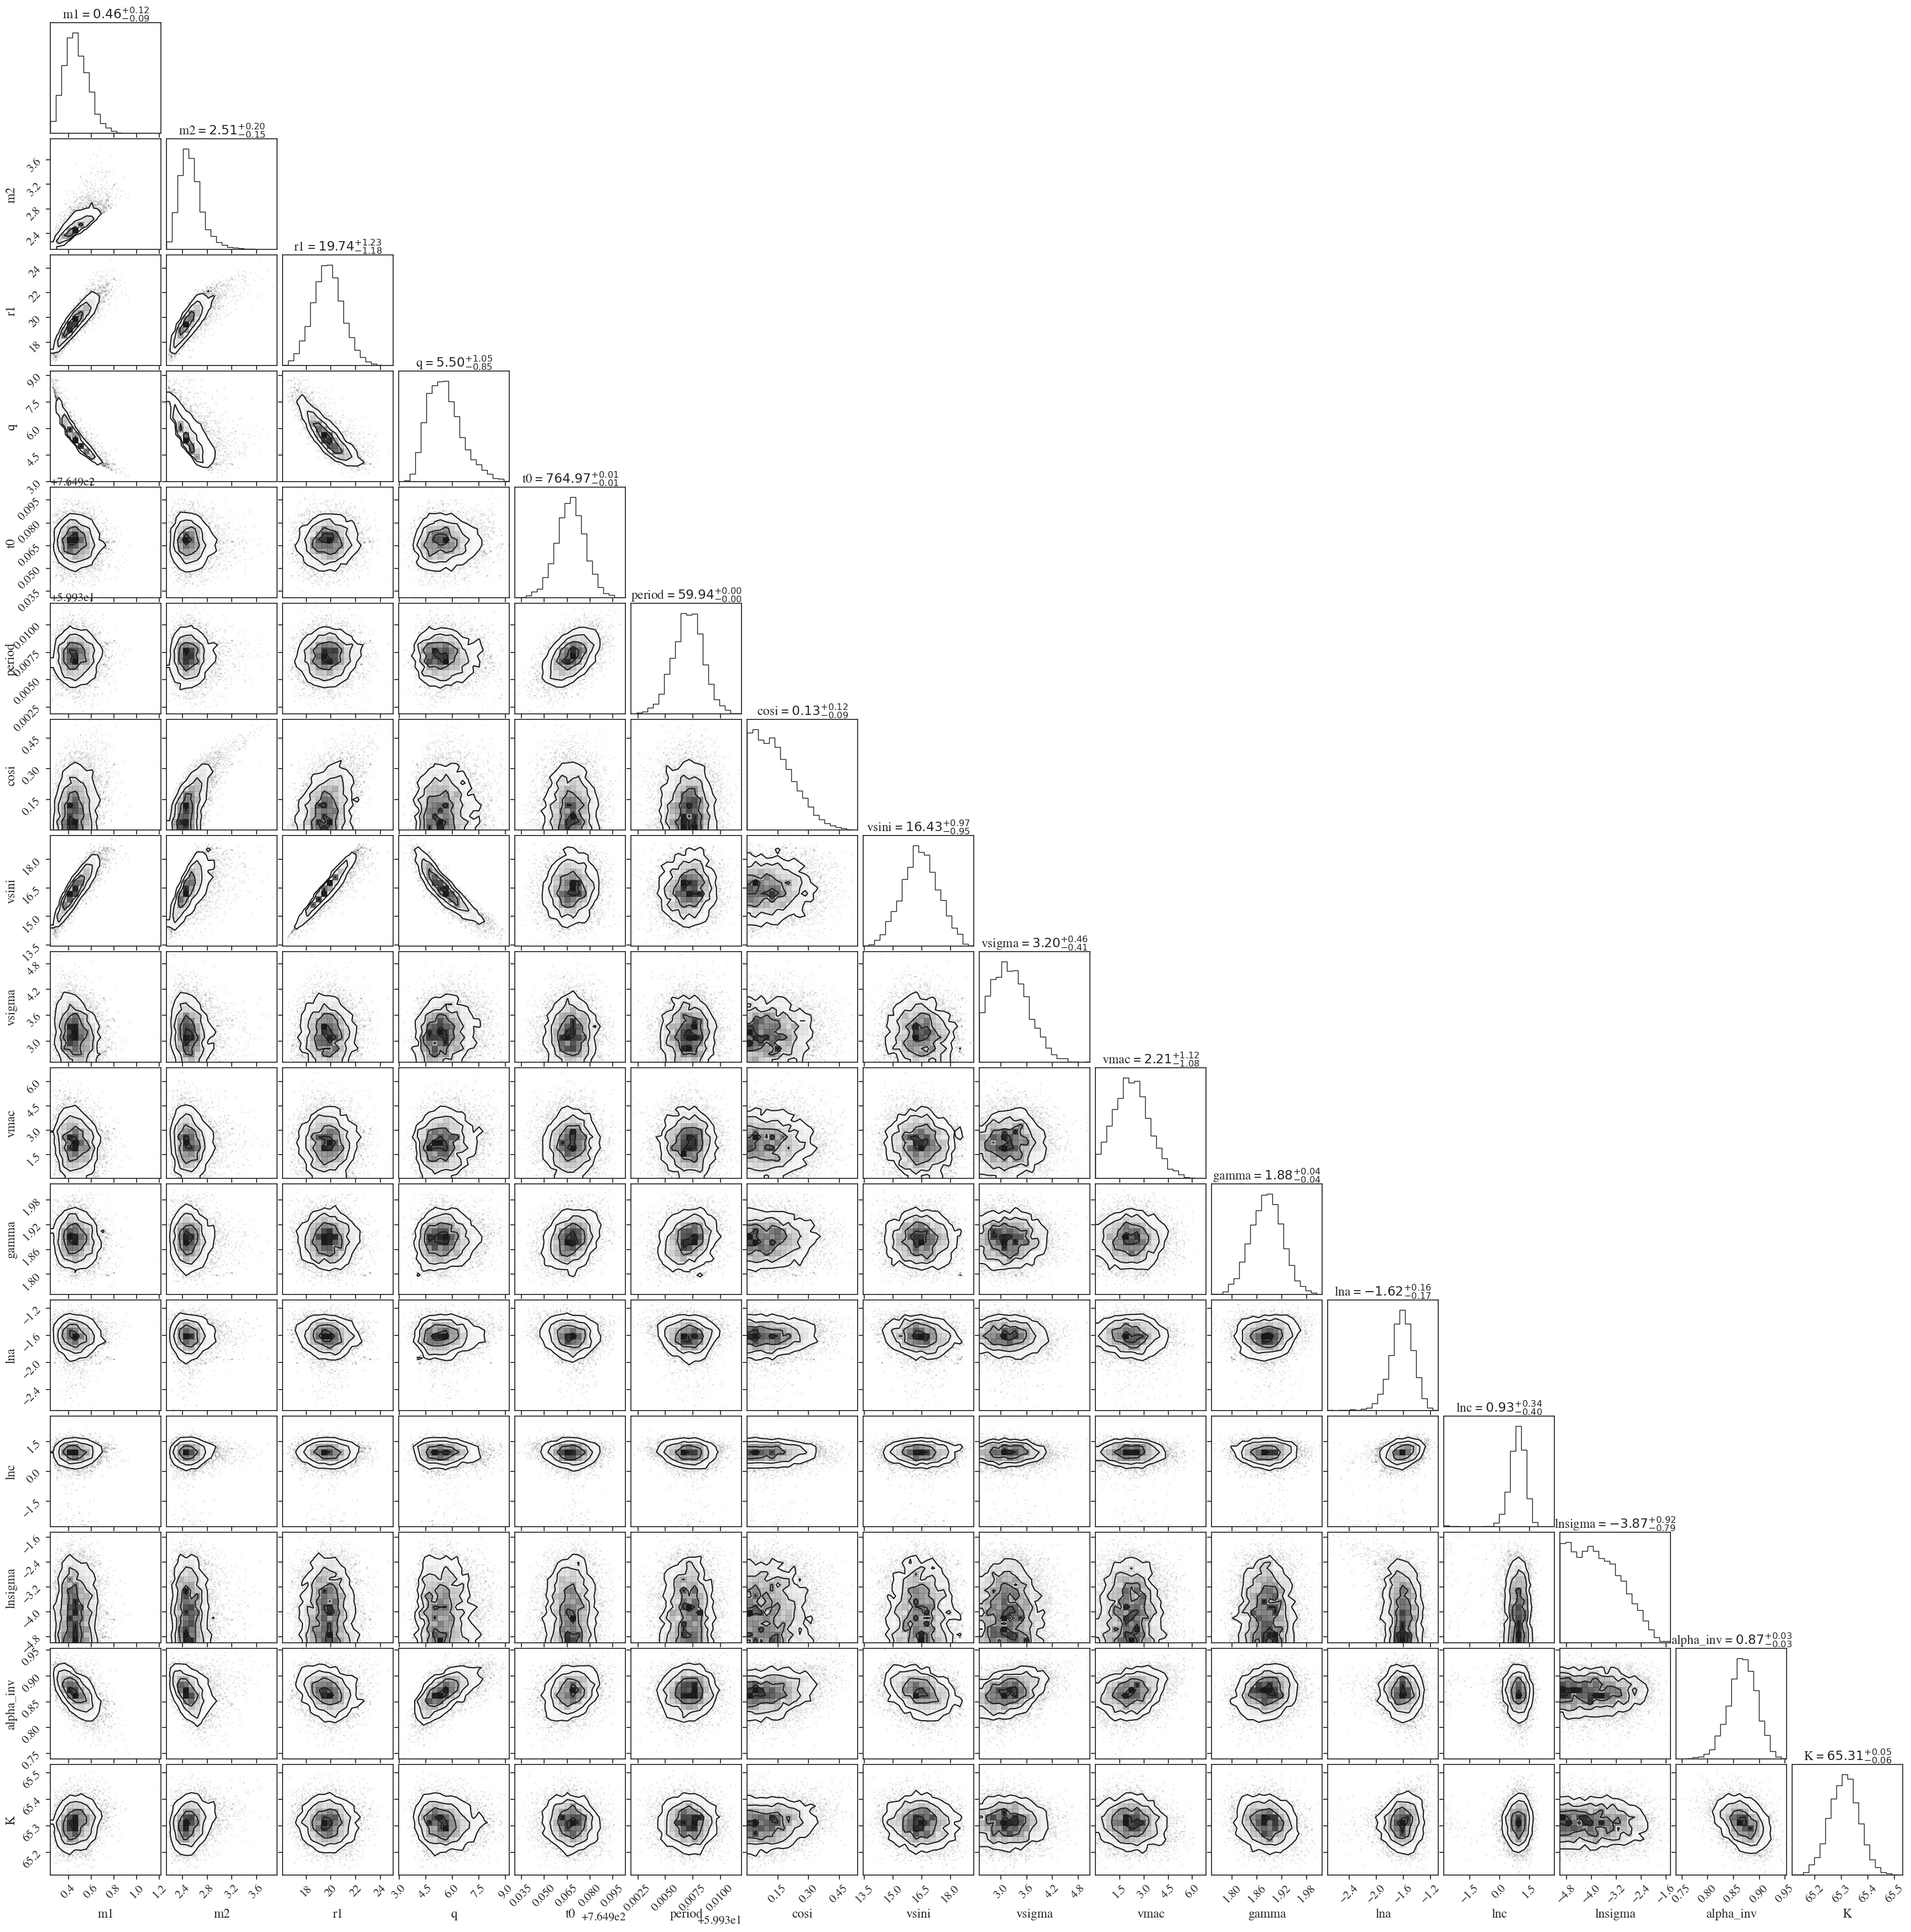

In [23]:
hyper = pd.DataFrame(data=dict(zip(keys, [samples[k] for k in keys])))
fig = corner.corner(np.array(hyper), labels=labels, show_titles="%.2f")
plt.savefig(basename+"_corner.png", dpi=200, bbox_inches="tight")